# Example projection of a neighborhood-based cell state abundance phenotype to test replication of csaQTL phenotype to attribute (sex)

In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import cna, pp, os
import statsmodels.api as sm
from projection import *
from figure_functions import *
pp.umapprops['s']=0.3

ref_folder = "/data/srlab/lrumker/datasets/onek1k/pheno/"
src_folder = "/data/srlab/lrumker/datasets/perez_sle/pheno/"
minor_types = {"NK": ["NK"], "T": ['T4',  'T8'], "Myeloid": ["cM", "ncM", 'cDC', 'pDC'], "B": ['B',  'PB']}
fig_dir="/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

## Compile results

In [2]:
all_res = pd.DataFrame()
for celltype in ["NK", "Myeloid", "B", "T"]:
    for cohort in ["ASI", "EUR"]:
        new = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/gwas_replication/replication_sex_"+celltype+"_"+cohort+".csv",
                     index_col=0)
        all_res = pd.concat([all_res, new])

In [3]:
all_res['beta_mod'] = all_res.beta.values/(1e-9)
all_res['stderr_mod'] = all_res.stderr.values/(1e-9)
all_res['hl'] = all_res.beta_mod.values+all_res.stderr_mod.values
all_res['ll'] = all_res.beta_mod.values-all_res.stderr_mod.values
all_res['celltype_cohort'] = [all_res.cohort.values[i]+", "+all_res.celltype.values[i] \
                              for i in np.arange(all_res.shape[0])]

In [4]:
all_res.to_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/gwas_replication/replication_sex.csv") # save 
all_res

,cohort,celltype,attr,P,beta,stderr,beta_mod,stderr_mod,hl,ll,celltype_cohort
0,ASI,NK,sex_M,1.706156e-15,3.393291e-09,3.608596e-10,3.393291,0.360860,3.754151,3.032432,"ASI, NK"
0,EUR,NK,sex_M,2.135330e-13,2.862370e-09,3.564875e-10,2.862370,0.356487,3.218858,2.505883,"EUR, NK"
0,ASI,Myeloid,sex_M,5.415605e-09,3.304307e-08,5.268957e-09,33.043072,5.268957,38.312030,27.774115,"ASI, Myeloid"
0,EUR,Myeloid,sex_M,4.704323e-08,2.707197e-08,4.798945e-09,27.071971,4.798945,31.870917,22.273026,"EUR, Myeloid"
0,ASI,B,sex_M,6.950069e-34,9.508664e-09,5.061918e-10,9.508664,0.506192,10.014856,9.002473,"ASI, B"
0,EUR,B,sex_M,4.867475e-24,8.928553e-09,7.259917e-10,8.928553,0.725992,9.654545,8.202561,"EUR, B"
0,ASI,T,sex_M,3.166094e-26,4.145543e-10,2.837329e-11,0.414554,0.028373,0.442928,0.386181,"ASI, T"
0,EUR,T,sex_M,1.087397e-14,2.658916e-10,3.107509e-11,0.265892,0.031075,0.296967,0.234816,"EUR, T"


## Plot example for a single major cell type

In [5]:
celltype="T"
    
# load discovery dataset
r = cna.read(ref_folder+celltype+".h5ad")
covs = ['age']
attr = 'sex_M'
cna.tl.nam(r, batches=r.samplem['batch'], covs = r.samplem[covs], ks=[r.samplem.shape[0]]) #to store all nampcs
res = cna.tl.association(r, r.samplem[attr], batches=r.samplem['batch'], covs = r.samplem[covs])
    
# Projection into Perez et al
covs_perez = ['age', 'sle']
cohort="EUR"
d = cna.read(src_folder+"symphony_output/projection_examples/"+cohort+"_"+celltype+".h5ad")

/data/srlab/lrumker/MCSC_Project/cna/src/cna/tools/_association.py:79: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


In [6]:
# Import NAM
NAM = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/gwas_replication/replication_sex_T_EUR_NAM.csv",
                 index_col=0)
NAM = np.array(NAM)

In [7]:
# Project phenotype to replication dataset
k = res.k
D = np.identity(len(r.uns['NAM_svs'][:k]))*r.uns['NAM_svs'][:k]
D_I = np.linalg.inv(D)
mask = np.abs(res.ncorrs)>res.fdr_10p_t
sampXpc = NAM[:,r.uns['keptcells']][:,mask].dot(r.uns['NAM_nbhdXpc'].iloc[:,:k].loc[mask,:]).dot(D_I)
est_pheno = np.dot(sampXpc[:,:k], res.beta).reshape(-1,)

In [8]:
# Visualize abundance correlation to sex observed per neighborhood in each dataset
empiric_corrs =[]
for i in np.arange(NAM.shape[1]):
    empiric_corrs.append(np.corrcoef(NAM[:,i], d.samplem[attr].values)[0,1])

In [9]:
# Phenotype-correlated genes reflect sex chromosome gene expression program
vargene_cors = []
for i_gene in np.arange(r.var.shape[0]):
    vargene_cors.append(np.corrcoef(r.X[res.kept, i_gene], res.ncorrs)[0,1])
vargene_cors=pd.DataFrame({'gene':r.var.index, 'cor': vargene_cors})
vargene_cors.iloc[np.argsort(vargene_cors.cor.values),:]

,gene,cor
1970,XIST,-0.417962
1002,PRKCQ-AS1,-0.137186
1972,JPX,-0.137142
692,LTB,-0.127202
1615,CCR7,-0.124665
...,...,...
2013,KDM5D,0.237176
2012,UTY,0.261971
2011,DDX3Y,0.322198
2009,USP9Y,0.322662


/tmp/ipykernel_63840/2498751738.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(fig_dir+"replication_sex.png")
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


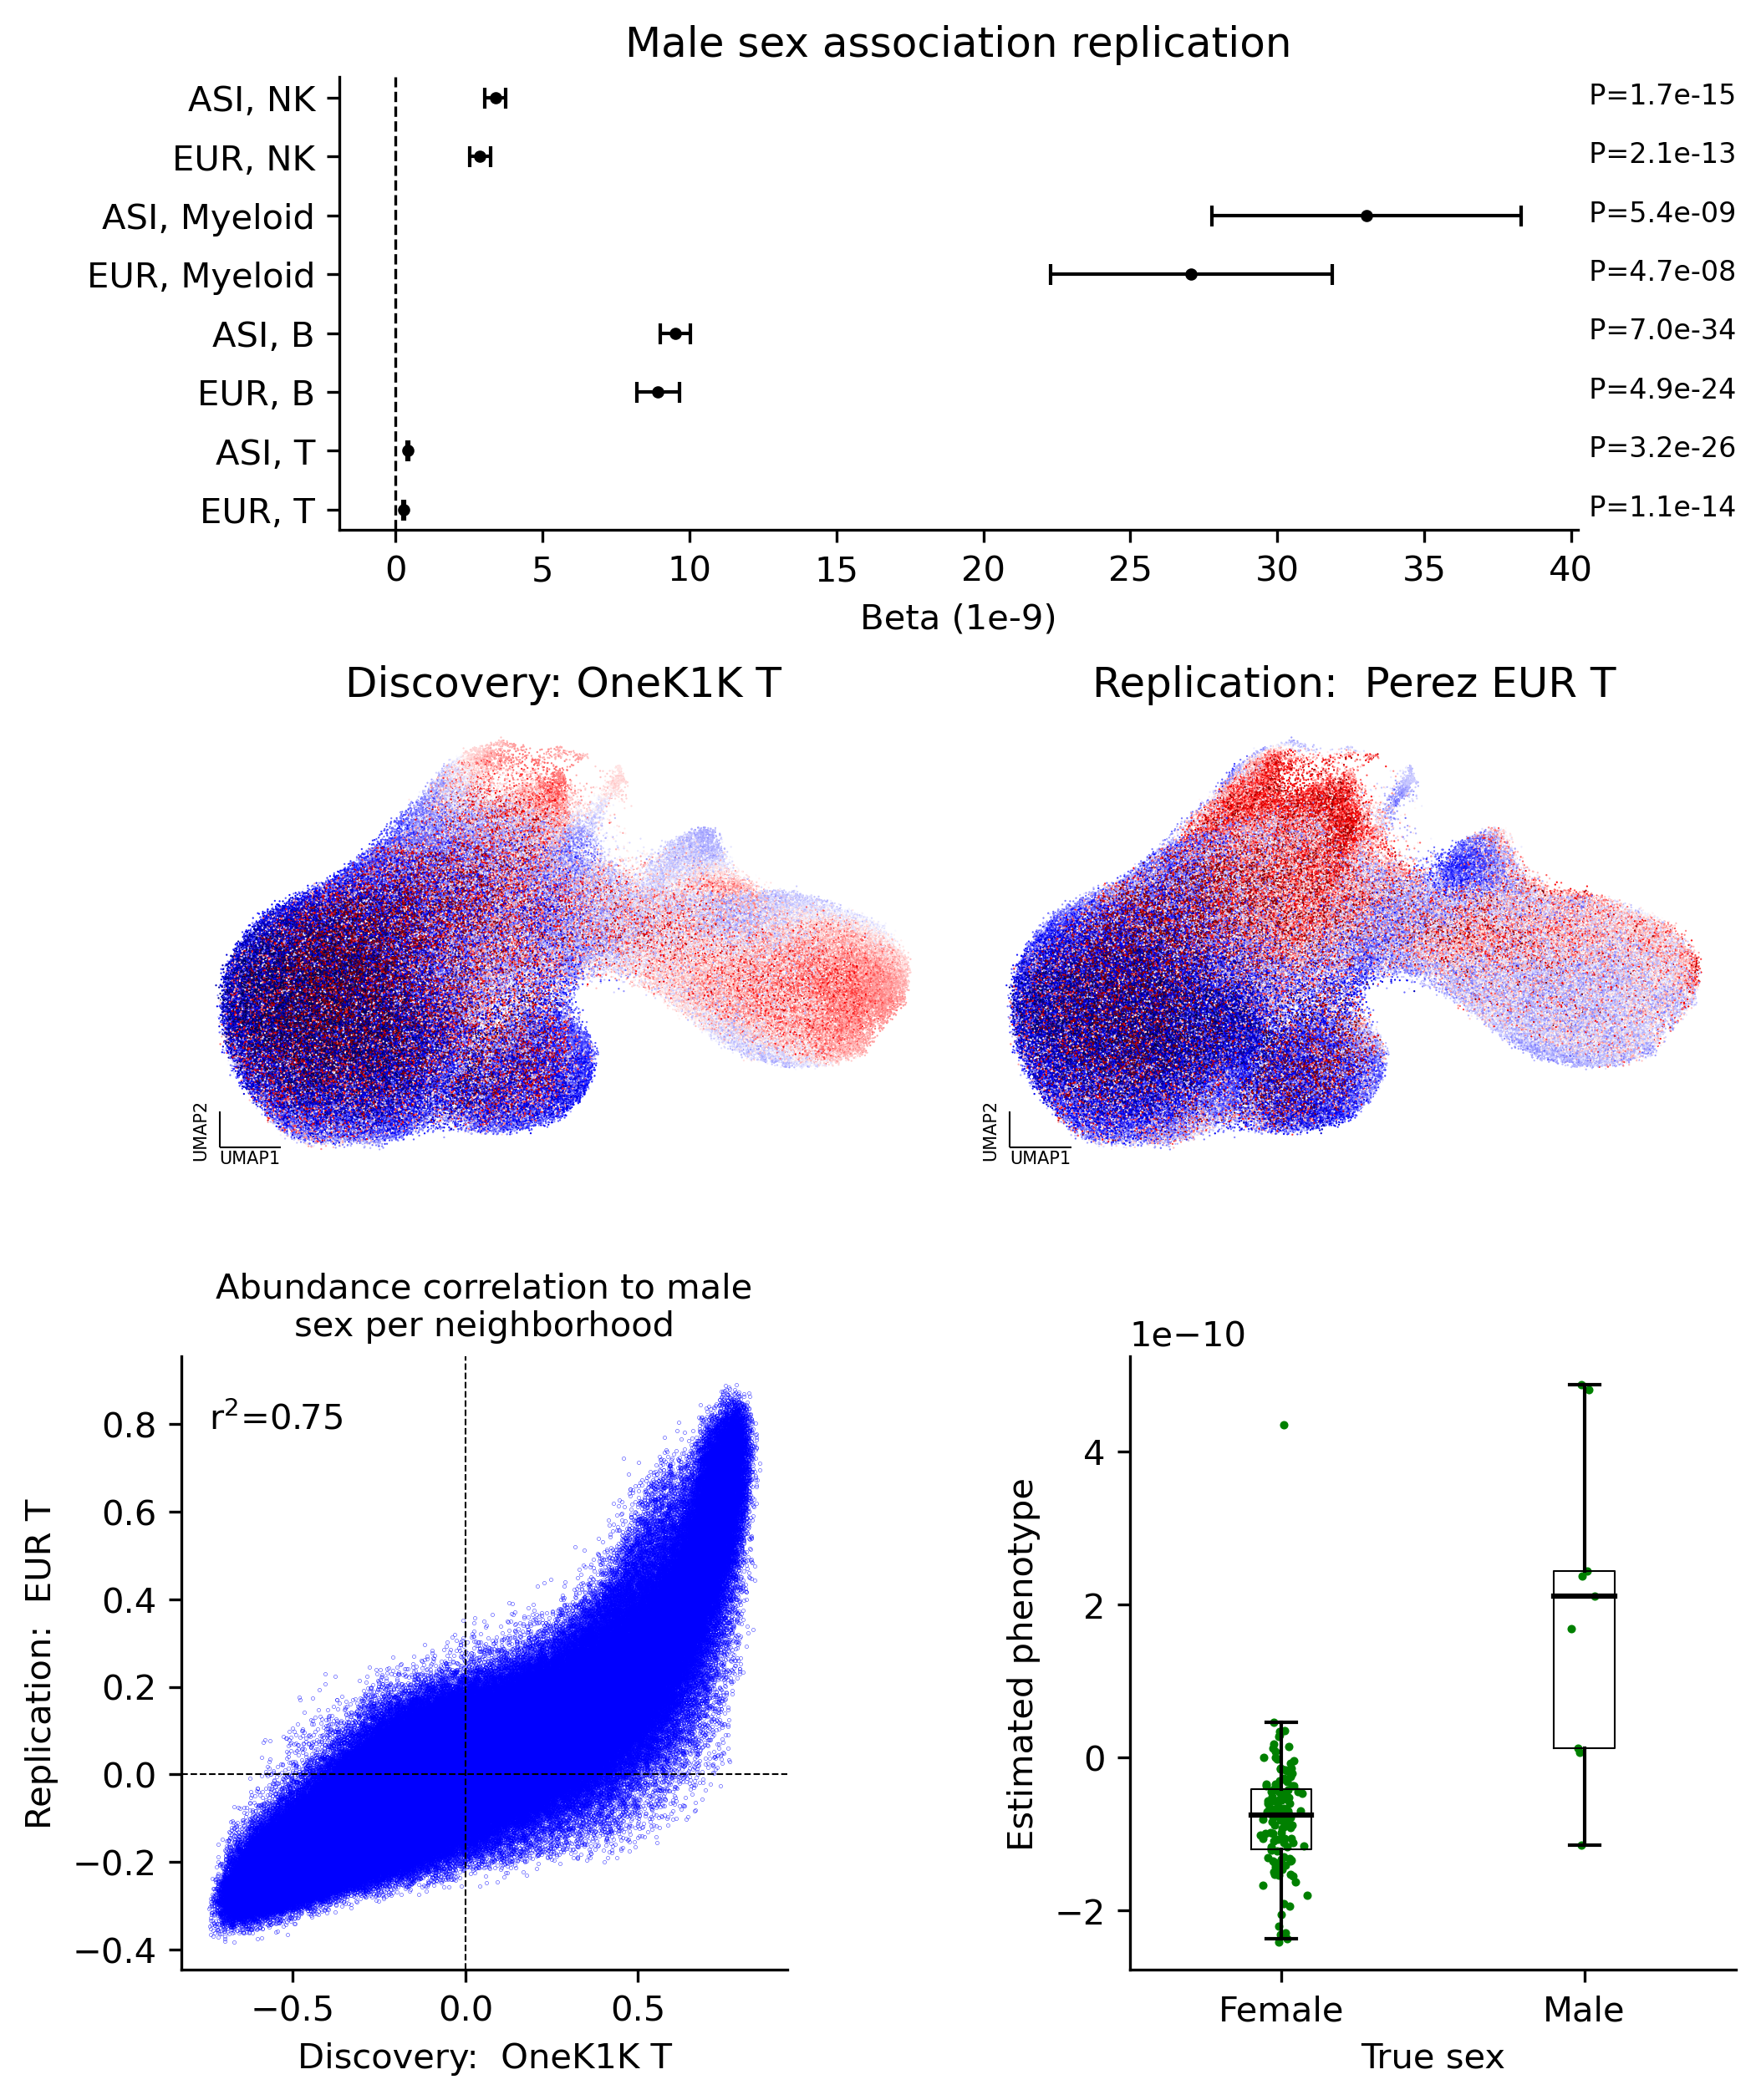

In [10]:
np.random.seed(0)
fig = plt.figure(tight_layout=True, figsize = (8,10), dpi=300)
gs = fig.add_gridspec(12, 10)
ax5 = fig.add_subplot(gs[0:3, 1:9])
ax1 = fig.add_subplot(gs[4:7, 0:5])
ax2 = fig.add_subplot(gs[4:7, 5:10])
ax3 = fig.add_subplot(gs[8:, 0:4])
ax4 = fig.add_subplot(gs[8:, 6:10])

pp.scatter_random(r.obsm['X_umap'][res.kept,0], r.obsm['X_umap'][res.kept,1],
                  c = res.ncorrs, ax = ax1, cmap="seismic")
ax1.set_title("Discovery: OneK1K T")
ax1.axis("off")

pp.scatter_random(r.obsm['X_umap'][res.kept,0], r.obsm['X_umap'][res.kept,1], 
                  c = np.array(empiric_corrs)[r.uns['keptcells']], ax = ax2, cmap = "seismic")
ax2.set_title("Replication:  Perez EUR T")
ax2.axis("off")

ax3.scatter(res.ncorrs, np.array(empiric_corrs)[r.uns['keptcells']], s = 0.01, c = "blue")
rsq=np.corrcoef(np.array(empiric_corrs)[r.uns['keptcells']], res.ncorrs)[0,1]**2
ax3.text(np.min(res.ncorrs), np.max(np.array(empiric_corrs)[r.uns['keptcells']])-0.1, "r$^2$="+str(np.around(rsq,2)))
ax3.set_xlabel("Discovery:  OneK1K T")
ax3.set_ylabel("Replication:  EUR T")
ax3.axvline(x=0, linewidth=0.5, linestyle='--', color='black')
ax3.axhline(y=0, linewidth=0.5, linestyle='--', color='black')
ax3.set_title("Abundance correlation to male\nsex per neighborhood", fontsize = 10)

x  = [np.array(est_pheno)[d.samplem.sex_M.values==0].reshape(-1,), 
      np.array(est_pheno)[d.samplem.sex_M.values==1].reshape(-1,)]
ax4.scatter(1+np.random.normal(0,0.03, size=len(x[0])), x[0], s = 2, c = "green")
ax4.scatter(2+np.random.normal(0, 0.03, size=len(x[1])), x[1], s = 2, c = "green")
ax4.boxplot(x, showfliers=False, widths = 0.2, medianprops=dict(color="black",linewidth=1.5),
           boxprops=dict(color="black",linewidth=0.5))
ax4.set_xlabel("True sex")
ax4.set_ylabel("Estimated phenotype")
ax4.set_xticks([1,2])
ax4.set_xticklabels(['Female', 'Male'])

mod_res = all_res.reset_index(drop = True)
mod_res['y'] = mod_res.index.values[::-1]
ci = mod_res.stderr_mod.values # plot one standard error above and below
ax5.axvline(x=0, linewidth=0.8, linestyle='--', color='black')
ax5.errorbar(x=mod_res.beta_mod.values, y=mod_res.y.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker=".", markersize=5, mfc="black", mec="black")
for i in np.arange(mod_res.shape[0]):
    ax5.text(40, mod_res.y[i]-0.1, "  P={:.1e}".format(mod_res.P[i]), fontsize = 8)
ax5.set_yticks(np.arange(mod_res.shape[0]))
ax5.set_yticklabels(mod_res.celltype_cohort.values[::-1])
ax5.set_xlabel('Beta (1e-9)')
ax5.set_title("Male sex association replication")

for ax in [ax3, ax4, ax5]:
    ax.spines[['right', 'top']].set_visible(False) # remove top / right spines
    
for ax in [ax1, ax2]:
    add_umap_axes(ax, umap_axis_length = 0.08, umap_axis_offset = 0.05, 
              axis_lw = 0.5, umap_text_size = 5)

plt.savefig(fig_dir+"replication_sex.png")
plt.show()

In [11]:
d.samplem.sex_M.value_counts()

0.0    131
1.0      9
Name: sex_M, dtype: int64